1. Calculate and view top-of-atmosphere energy imbalance in fully-coupled model
2. Calculate surface temperature anomalies in fixed-SST simulations
3. Calculate (Hansen-adjusted) ERF
4. Also visualize sea level pressure, wind, and precipitation anomalies

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import nctoolkit as nct

import cartopy.crs as ccrs
import proplot as pplt
import xarray

nctoolkit is using Climate Data Operators version 1.9.9


In [2]:
my_dir = '/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM1.2/fixed_SSTs'
fcm_dir = '/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM1.2/FCM'
cesm2_dir = '/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM2/fixed_SSTs'

In [3]:
sstice = xarray.open_dataset('%s/b.e21.B1850.f09_g17.CMIP6-piControl.001_sst_cpl.c.192x288.nc' %(cesm2_dir))

In [4]:
f_piControl = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.284.7.cam.h0.06-33yrs.nc' %(cesm2_dir))
f_co2 = xarray.open_dataset('%s/f.e21.B1850.f09_f09.CMIP6-piControl.new.569.4.cam.h0.FNS.FNT.TS.ICEFRAC.06-33yrs.nc' %(cesm2_dir))
f_plio = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.400.cam.h0.T.FNT.FNS.ICE.LANDFRAC.WIND.06-30yrs.nc' %(cesm2_dir))
f_plio_280 = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.284.7.cam.h0.T.FNT.FNS.ICE.LANDFRAC.WIND.06-35yrs.nc' %(cesm2_dir))
f_400 = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.400.cam.h0.TEMP.ICE.FORCING.SHOW.06-33yrs.nc' %(cesm2_dir))

In [5]:
f_pi_precip = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.284.7.cam.h0.PRECIP.06-33yrs.nc' %(cesm2_dir))
f_plio_precip = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.400.cam.h0.PRECIP.06-30yrs.nc' %(cesm2_dir))
f_plio_280_precip = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.284.7.cam.h0.PRECIP.06-35yrs.nc' %(cesm2_dir))
f_400_precip = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.400.cam.h0.TREFHT.PSL.PRECIP.WIND.01-33yrs.nc' %(cesm2_dir)).sel(time=slice('0006-01-01','0033-12-01'))

In [6]:
f_pi_ref_slp = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.284.7.cam.h0.TREFHT.PSL.nc' %(cesm2_dir))
f_plio_ref_slp = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.400.0.cam.h0.TREFHT.PSL.nc' %(cesm2_dir))
f_plio_280_ref_slp = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.284.7.cam.h0.TREFHT.PSL.nc' %(cesm2_dir))
f_400_ref_slp = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.400.cam.h0.TREFHT.PSL.PRECIP.WIND.01-33yrs.nc' %(cesm2_dir)).sel(time=slice('0006-01-01','0033-12-01'))

In [7]:
f_pi_wind = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.284.7.cam.h0.WIND.nc' %(cesm2_dir))
f_plio_wind = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.400.0.cam.h0.WIND.nc' %(cesm2_dir))
f_plio_280_wind = xarray.open_dataset('%s/f.e21.F1850.f09_f09.PMIP4-midPliocene.new.284.7.cam.h0.WIND.nc' %(cesm2_dir))
f_400_wind = xarray.open_dataset('%s/f.e21.F1850.f09_f09.CMIP6-piControl.new.400.cam.h0.TREFHT.PSL.PRECIP.WIND.01-33yrs.nc' %(cesm2_dir)).sel(time=slice('0006-01-01','0033-12-01'))

In [8]:
# mask = xarray.open_dataset('/tdat/mdvorak/CMIP6/Pliocene/domain.lnd.fv0.9_1.25_gx1v6plioenh.190801.nc')
# mask['ni'] = mask.mask.xc[0,:]
# mask['nj'] = mask.mask.yc[:,0]

# mask = mask.rename(ni='lon',nj='lat')

mask = xarray.open_dataset('/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM1.2/SOM/Pliocene_mask.nc')

In [9]:
def time_weights(ds):
    month_length = ds.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xarray.ALL_DIMS), 1.0)
    
    return wgts

In [10]:
def lat_weights(ds):
    clat = np.cos(np.deg2rad(ds.lat)) 
    return clat / np.sum(clat) 

In [11]:
e_dir = '/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM2/SOM'

ocnfrac_pi = xarray.open_dataset('%s/e.e21.E1850.f09_g17.CMIP6-piControl.new.OCNFRAC.34-84yrs.nc' %(e_dir))
ocnfrac_plio = xarray.open_dataset('%s/e.e21.E1850.f09_g17.PMIP4-midPliocene.piflx.400.cam.h0.OCNFRAC.76-126yrs.nc' %(e_dir))

In [21]:
#Pull up fully coupled simulations to calculate TOA imbalance.

new_dir = '/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM2'

In [23]:
# need to load LW, SW variables separately for existing fully-coupled piControl simulation

b_piControl_FLNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h0.FLNT.190001-200012.nc' %(new_dir)) # last 100 years
b_piControl_FSNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h0.FSNT.190001-200012.nc' %(new_dir))

b_co2_FLNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.CMIP6-piControl.400.cam.h0.FLNT.812-902yrs.nc' %(new_dir))
b_co2_FSNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.CMIP6-piControl.400.cam.h0.FSNT.812-902yrs.nc' %(new_dir)) # last 40 years only

b_plio_FLNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.PMIP4-midPliocene-eoi400.001.cam.h0.FLNT.115101-120012.nc' %(new_dir)) # last 50 years
b_plio_FSNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.PMIP4-midPliocene-eoi400.001.cam.h0.FSNT.115101-120012.nc' %(new_dir))

b_plio_pi_FLNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.PMIP4-midPliocene-eoi400.284.7.cam.h0.FLNT.035101-040512.nc' %(new_dir)) # last 50 years
b_plio_pi_FSNT = xarray.open_dataset('%s/b.e21.B1850.f09_g17.PMIP4-midPliocene-eoi400.284.7.cam.h0.FSNT.035101-040512.nc' %(new_dir))

In [31]:
def b_case_weighted(ds_lw, ds_sw):
    time_weighted = -ds_lw.FLNT.weighted(time_weights(ds_lw)).mean('time') + ds_sw.FSNT.weighted(time_weights(ds_sw)).mean('time')
    spatial_weighted = time_weighted.weighted(lat_weights(ds_lw)).mean(('lat','lon'))
    
    return spatial_weighted

Confirm that the TOA imbalance is ~0 for both the preindustrial control and Pliocene b.c. climatologies
Calculate the spatially-averaged net radiative flux

In [37]:
b_pi_net = b_case_weighted(b_piControl_FLNT, b_piControl_FSNT)
b_plio_net = b_case_weighted(b_plio_FLNT, b_plio_FSNT)
b_plio_pi_net = b_case_weighted(b_plio_pi_FLNT, b_plio_pi_FSNT)
b_co2_net = b_case_weighted(b_co2_FLNT, b_co2_FSNT)

In [38]:
print(b_plio_net - b_pi_net)
print(b_plio_pi_net - b_pi_net)
print(b_co2_net - b_pi_net)

<xarray.DataArray ()>
array(0.24774447)
<xarray.DataArray ()>
array(0.02901133)
<xarray.DataArray ()>
array(0.14126178)


Text(0.5, 1.0, '400ppm FCM TOA imbalance relative to PI')

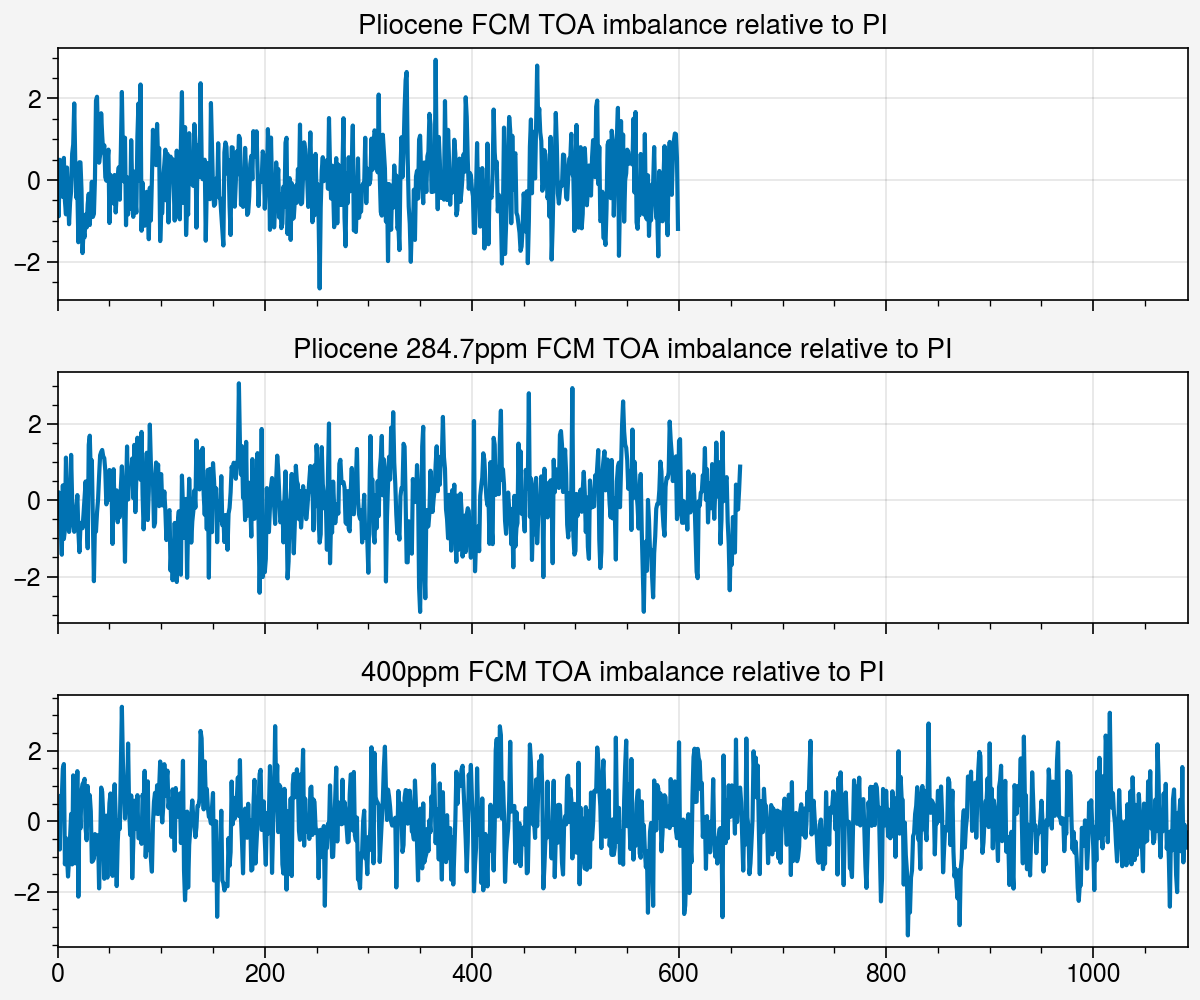

In [27]:
# look at timeseries of N in case of drift:

fig, ax = pplt.subplots(ncols=1,nrows=3, figsize=(6,5))
N_plio = ((b_plio_FSNT.FSNT - b_piControl_FSNT.FSNT.mean('time')) - (b_plio_FLNT.FLNT - b_piControl_FLNT.FLNT.mean('time'))).weighted(atm_weights).mean(("lat","lon"))
N_plio_pi = ((b_plio_pi_FSNT.FSNT - b_piControl_FSNT.FSNT.mean('time')) - (b_plio_pi_FLNT.FLNT - b_piControl_FLNT.FLNT.mean('time'))).weighted(atm_weights).mean(("lat","lon"))
N_co2 = ((b_co2_FSNT.FSNT - b_piControl_FSNT.FSNT.mean('time')) - (b_co2_FLNT.FLNT - b_piControl_FLNT.FLNT.mean('time'))).weighted(atm_weights).mean(("lat","lon"))

N_plio = N_plio.groupby('time.month') - N_plio.groupby('time.month').mean('time')
N_plio_pi = N_plio_pi.groupby('time.month') - N_plio_pi.groupby('time.month').mean('time')
N_co2 = N_co2.groupby('time.month') - N_co2.groupby('time.month').mean('time')

ax[0].plot(np.asarray(N_plio))
ax[0].set_title('Pliocene FCM TOA imbalance relative to PI')
ax[1].plot(np.asarray(N_plio_pi))
ax[1].set_title('Pliocene 284.7ppm FCM TOA imbalance relative to PI')
ax[2].plot(np.asarray(N_co2))
ax[2].set_title('400ppm FCM TOA imbalance relative to PI')

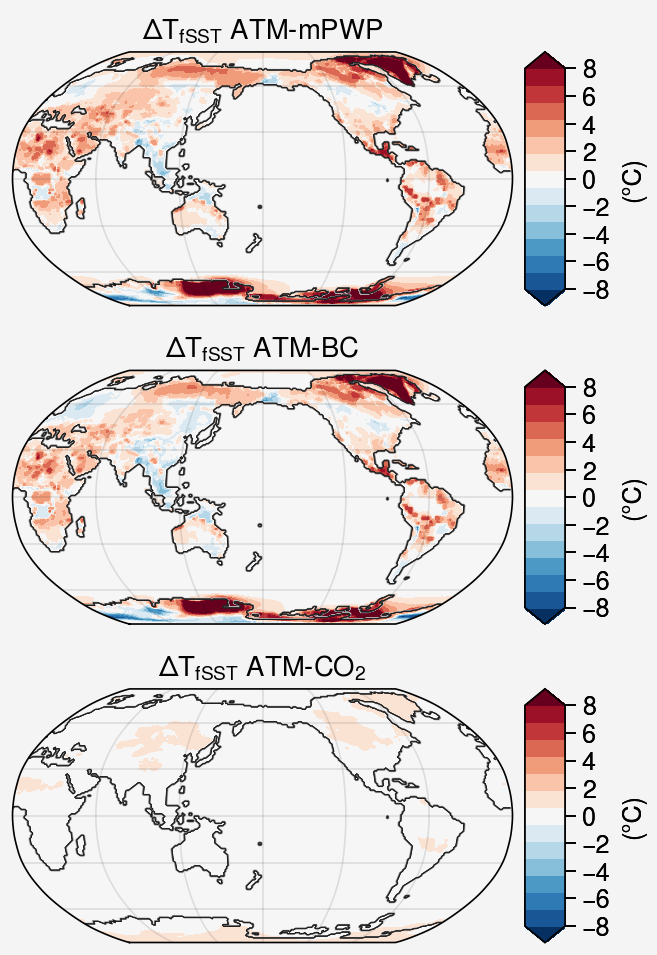

In [ ]:
fig, axes = pplt.subplots(nrows=3, ncols=1, proj='robin', proj_kw={'lon_0': 180})

for i,ax in enumerate(axes):
    cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
    cp = ax.contourf(T_surf_spatial[i], cmap='RdBu_r', levels=np.linspace(-8,8,14), extend='both')
    ax.colorbar(cp,label='(°C)', ticks=2, length=1.0)
#ax.coastlines()
axes[0].set_title('\u0394T$_{fSST}$ ATM-mPWP')
axes[1].set_title('\u0394T$_{fSST}$ ATM-BC')
axes[2].set_title('\u0394T$_{fSST}$ ATM-CO$_2$');

In [13]:
def calc_net(sim):
    
    f_weights = np.cos(np.deg2rad(f_plio_280.lat))
    
    return (sim.FSNT - sim.FLNT).weighted(time_weights(sim)).mean('time').weighted(f_weights).mean(("lat","lon")) - (f_piControl.FSNT - f_piControl.FLNT).weighted(time_weights(f_piControl)).mean('time').weighted(f_weights).mean(("lat","lon"))

def calc_SW(sim):    
    
    return (sim.FSNT).weighted(time_weights(sim)).mean('time').weighted(f_weights).mean(("lat","lon")) - (f_piControl.FSNT).weighted(time_weights(f_piControl)).mean('time').weighted(f_weights).mean(("lat","lon"))

def calc_LW(sim):    
    
    return -(sim.FLNT).weighted(time_weights(sim)).mean('time').weighted(f_weights).mean(("lat","lon")) + (f_piControl.FLNT).weighted(time_weights(f_piControl)).mean('time').weighted(f_weights).mean(("lat","lon"))

def calc_temp(sim):
    return (sim.TS).weighted(time_weights(sim)).mean('time').weighted(lat_weights(f_weights)).mean(("lat","lon")) - f_piControl.TS.weighted(time_weights(f_piControl)).mean('time').weighted(lat_weights(f_weights)).mean(("lat","lon"))

In [14]:
def calc_net_spatial(sim):
    
    return (sim.FSNT - sim.FLNT).weighted(time_weights(sim)).mean('time') - (f_piControl.FSNT - f_piControl.FLNT).weighted(time_weights(f_piControl)).mean('time')

def calc_SW_spatial(sim):    
    
    return (sim.FSNT).weighted(time_weights(sim)).mean('time') - (f_piControl.FSNT).weighted(time_weights(f_piControl)).mean('time')

def calc_LW_spatial(sim):    
    
    return -(sim.FLNT).weighted(time_weights(sim)).mean('time') + (f_piControl.FLNT).weighted(time_weights(f_piControl)).mean('time')

def calc_temp_spatial(sim):
    return (sim.TS).weighted(time_weights(sim)).mean('time') - f_piControl.TS.weighted(time_weights(f_piControl)).mean('time')

In [15]:
sims = [f_plio, f_plio_280, f_400, f_co2]

In [16]:
net_ave = [calc_net(sim) for sim in sims]
SW_ave = [calc_SW(sim) for sim in sims]
LW_ave = [calc_LW(sim) for sim in sims]

T_surf = [calc_temp(sim) for sim in sims]

In [17]:
net_spatial = [calc_net_spatial(sim) for sim in sims]
SW_spatial = [calc_SW_spatial(sim) for sim in sims]
LW_spatial = [calc_LW_spatial(sim) for sim in sims]

T_surf_spatial = [calc_temp_spatial(sim) for sim in sims]

In [18]:
def hansen_adj(kind):

    return [sim - T_surf[i] * -1.01 for i,sim in enumerate(kind)]

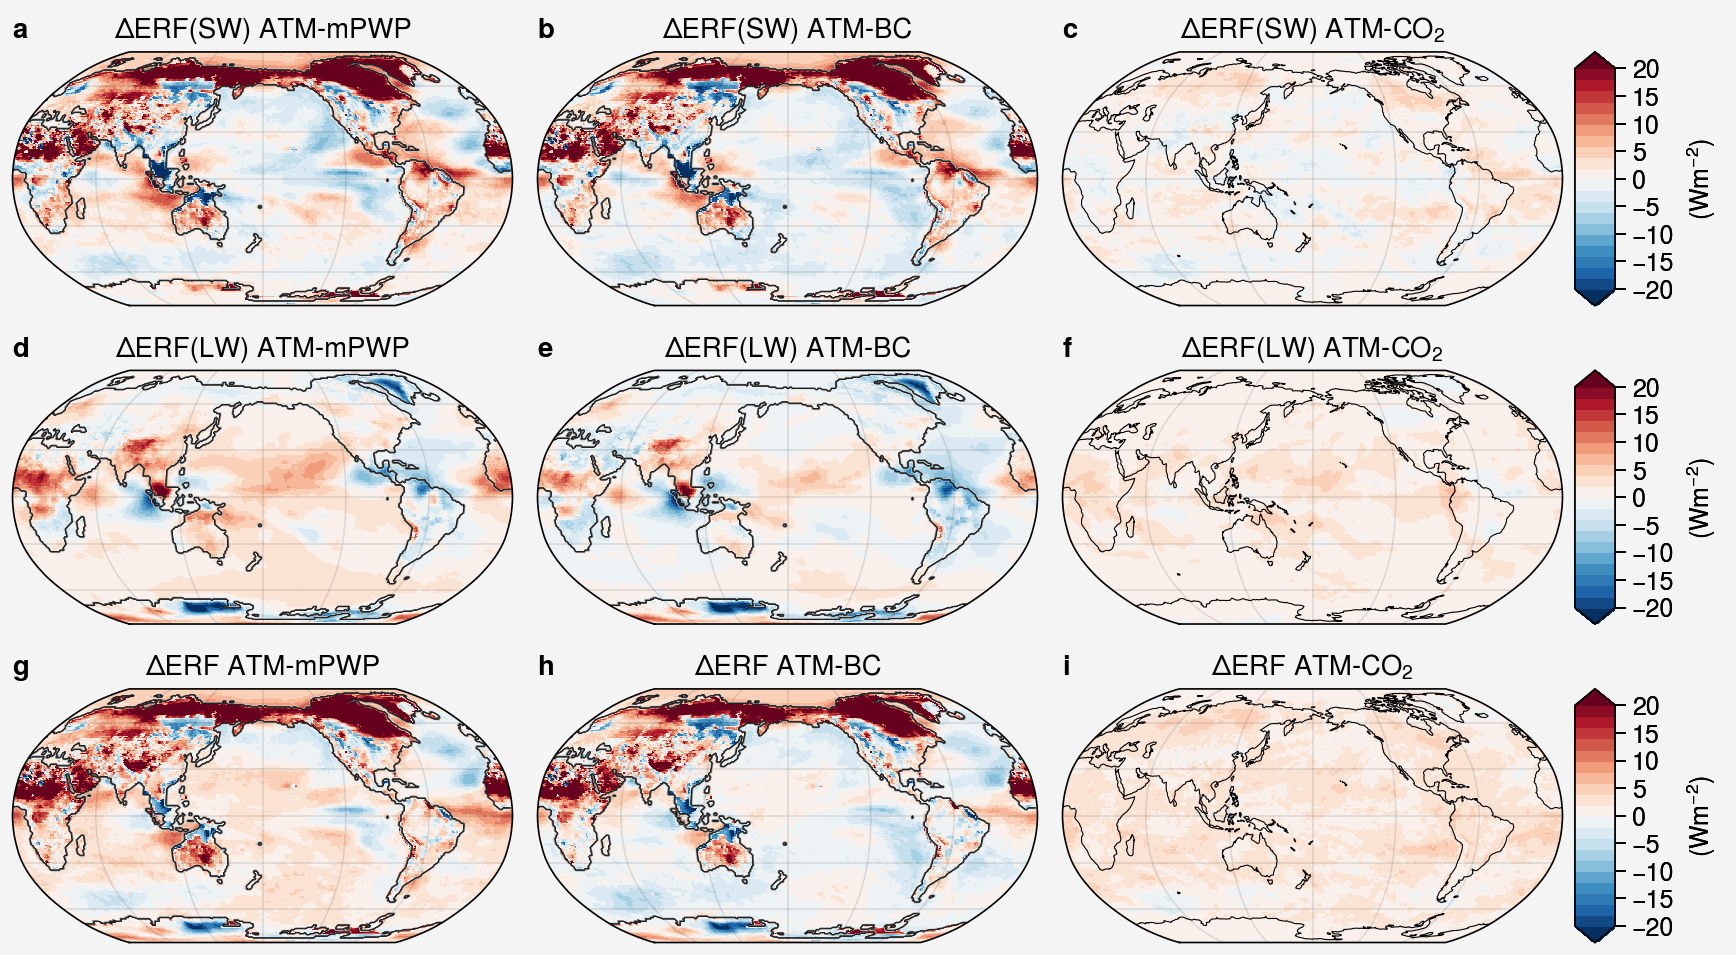

In [73]:
plt.rcParams["font.size"] = 9

fig, axes = pplt.subplots(nrows=3, ncols=3, proj='robin', proj_kw={'lon_0': 180})

for i,ax in enumerate(axes[:3]):
    cp = ax.pcolormesh(SW_spatial[i] + 1.01*T_surf[i], cmap='RdBu_r', levels=np.linspace(-20,20,21), extend='both')
    
    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)

axes[2].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[0].set_title('\u0394ERF(SW) ATM-mPWP')
axes[1].set_title('\u0394ERF(SW) ATM-BC')
axes[2].set_title('\u0394ERF(SW) ATM-CO$_2$')
axes[2].coastlines(linewidth=0.4)

for i,ax in enumerate(axes[3:6]):
    cp = ax.pcolormesh(LW_spatial[i] + 1.01*T_surf[i], cmap='RdBu_r', levels=np.linspace(-20,20,21), extend='both')
    
    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
            
axes[5].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[3].set_title('\u0394ERF(LW) ATM-mPWP')
axes[4].set_title('\u0394ERF(LW) ATM-BC')
axes[5].set_title('\u0394ERF(LW) ATM-CO$_2$')
axes[5].coastlines(linewidth=0.4)
            
for i,ax in enumerate(axes[6:]):
    cp = ax.pcolormesh(net_spatial[i] + 1.01*T_surf[i], cmap='RdBu_r', levels=np.linspace(-20,20,21), extend='both')

    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
    
            
axes[8].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[6].set_title('\u0394ERF ATM-mPWP')
axes[7].set_title('\u0394ERF ATM-BC')
axes[8].set_title('\u0394ERF ATM-CO$_2$')
axes[8].coastlines(linewidth=0.4)

fig.format(abc=True)
plt.savefig('/data0/mdvorak/tdat/CMIP6/Pliocene/tos/CESM2/figures/ERF_figure_adj.pdf');

In [ ]:
# Planck scaling

def scale_SB(list_of_arr):
    
    empty_list = []
    
    for i in range(len(list_of_arr)):
    
        arr_scaled = xarray.DataArray.copy(list_of_arr[i])

        arr_scaled = arr_scaled.where(arr_scaled < 0, arr_scaled**(1/4))
        arr_scaled = arr_scaled.where(arr_scaled > 0, -(np.abs(arr_scaled)**(1/4)))

        empty_list.append(arr_scaled)
    
    return empty_list

In [27]:
SW_diff_allsky = [f_plio.FSNT.mean("time") - f_piControl.FSNT.mean("time"), f_plio_280.FSNT.mean("time") - f_piControl.FSNT.mean("time"), 
           f_400.FSNT.mean("time") - f_piControl.FSNT.mean("time")]

LW_diff_allsky = [-(f_plio.FLNT.mean("time") - f_piControl.FLNT.mean("time")), -(f_plio_280.FLNT.mean("time") - f_piControl.FLNT.mean("time")),
          -(f_400.FLNT.mean("time") - f_piControl.FLNT.mean("time"))]

net_diff_allsky = [(f_plio.FSNT.mean("time") - f_piControl.FSNT.mean("time")) - (f_plio.FLNT.mean("time") - f_piControl.FLNT.mean("time")),
            (f_plio_280.FSNT.mean("time") - f_piControl.FSNT.mean("time")) - (f_plio_280.FLNT.mean("time") - f_piControl.FLNT.mean("time")),
            (f_400.FSNT.mean("time") - f_piControl.FSNT.mean("time")) - (f_400.FLNT.mean("time") - f_piControl.FLNT.mean("time"))]

SW_diff_clouds = [SW_diff_allsky[0] - SW_diff[0], SW_diff_allsky[1] - SW_diff[1], SW_diff_allsky[2] - SW_diff[2]]
LW_diff_clouds = [LW_diff_allsky[0] - LW_diff[0], LW_diff_allsky[1] - LW_diff[1], LW_diff_allsky[2] - LW_diff[2]]
net_diff_clouds = [net_diff_allsky[0] - net_diff[0], net_diff_allsky[1] - net_diff[1], net_diff_allsky[2] - net_diff[2]]

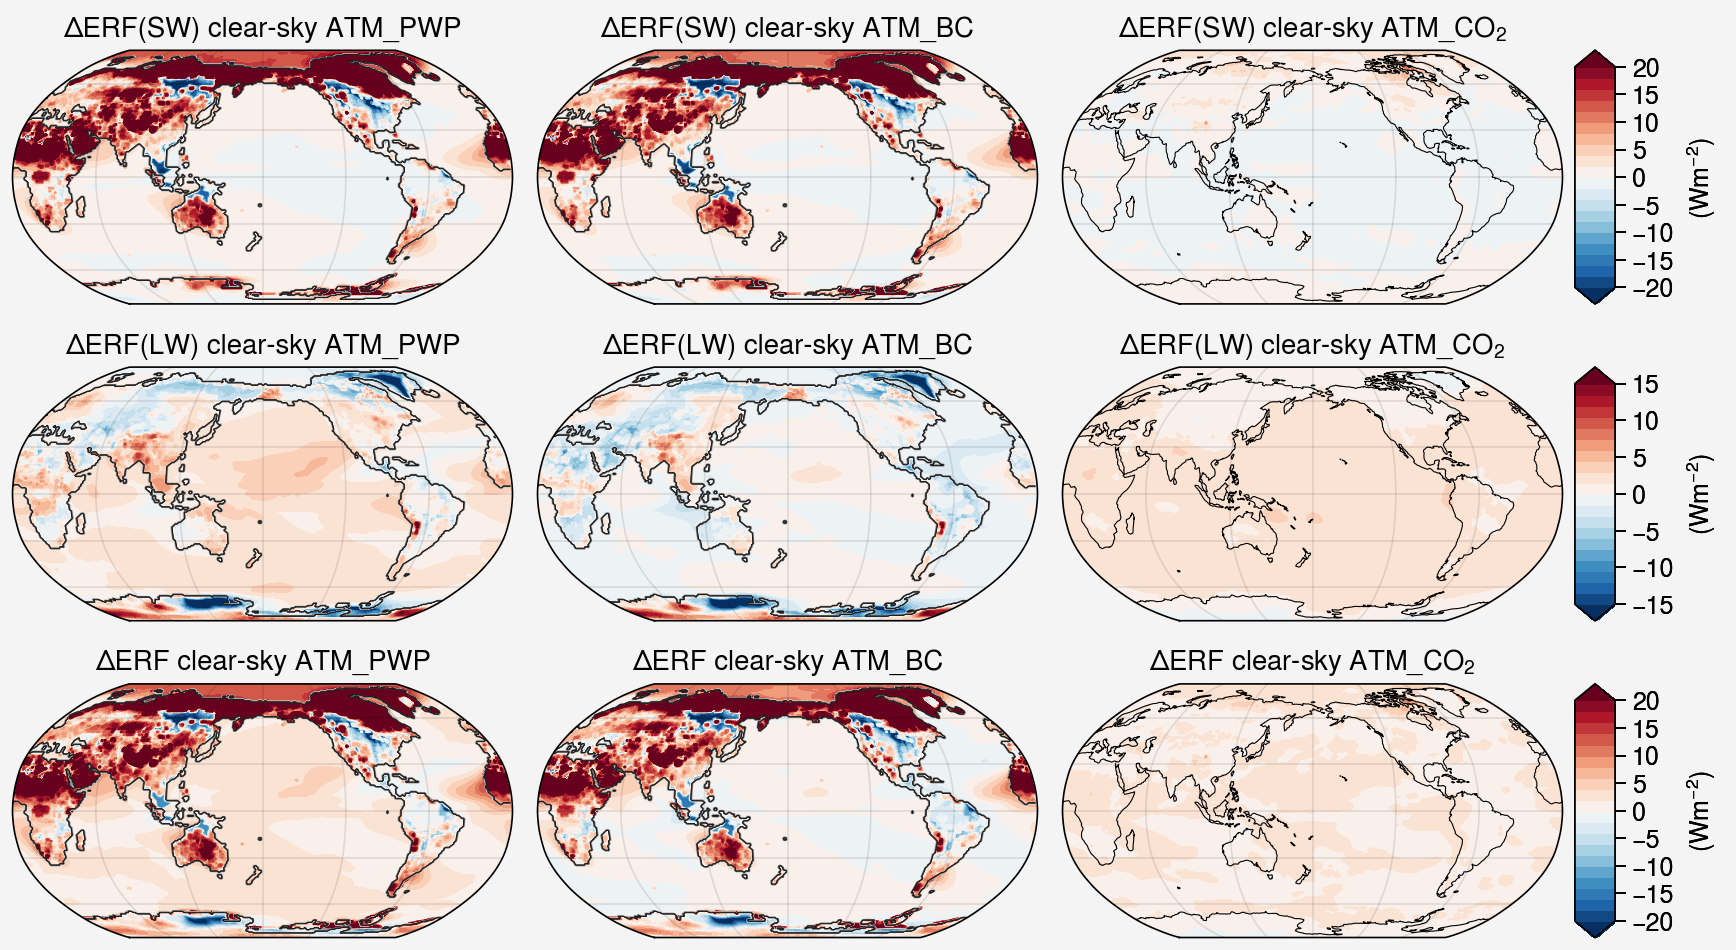

In [28]:
plt.rcParams["font.size"] = 9

fig, axes = pplt.subplots(nrows=3, ncols=3, proj='robin', proj_kw={'lon_0': 180})

for i,ax in enumerate(axes[:3]):
    cp = ax.contourf(SW_diff[i], cmap='RdBu_r', N=np.linspace(-20,20,21), extend='both')
    
    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)

axes[2].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[0].set_title('\u0394ERF(SW) clear-sky ATM-mPWP')
axes[1].set_title('\u0394ERF(SW) clear-sky ATM-BC')
axes[2].set_title('\u0394ERF(SW) clear-sky ATM-CO$_2$')
axes[2].coastlines(linewidth=0.4)

for i,ax in enumerate(axes[3:6]):
    cp = ax.contourf(LW_diff[i], cmap='RdBu_r', N=np.linspace(-15,15,21), extend='both')
    
    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
            
axes[5].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[3].set_title('\u0394ERF(LW) clear-sky ATM-mPWP')
axes[4].set_title('\u0394ERF(LW) clear-sky ATM-BC')
axes[5].set_title('\u0394ERF(LW) clear-sky ATM-CO$_2$')
axes[5].coastlines(linewidth=0.4)
            
for i,ax in enumerate(axes[6:]):
    cp = ax.contourf(net_diff[i], cmap='RdBu_r', N=np.linspace(-20,20,21), extend='both')

    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
    
            
axes[8].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[6].set_title('\u0394ERF clear-sky ATM-mPWP')
axes[7].set_title('\u0394ERF clear-sky ATM-BC')
axes[8].set_title('\u0394ERF clear-sky ATM-CO$_2$')
axes[8].coastlines(linewidth=0.4);

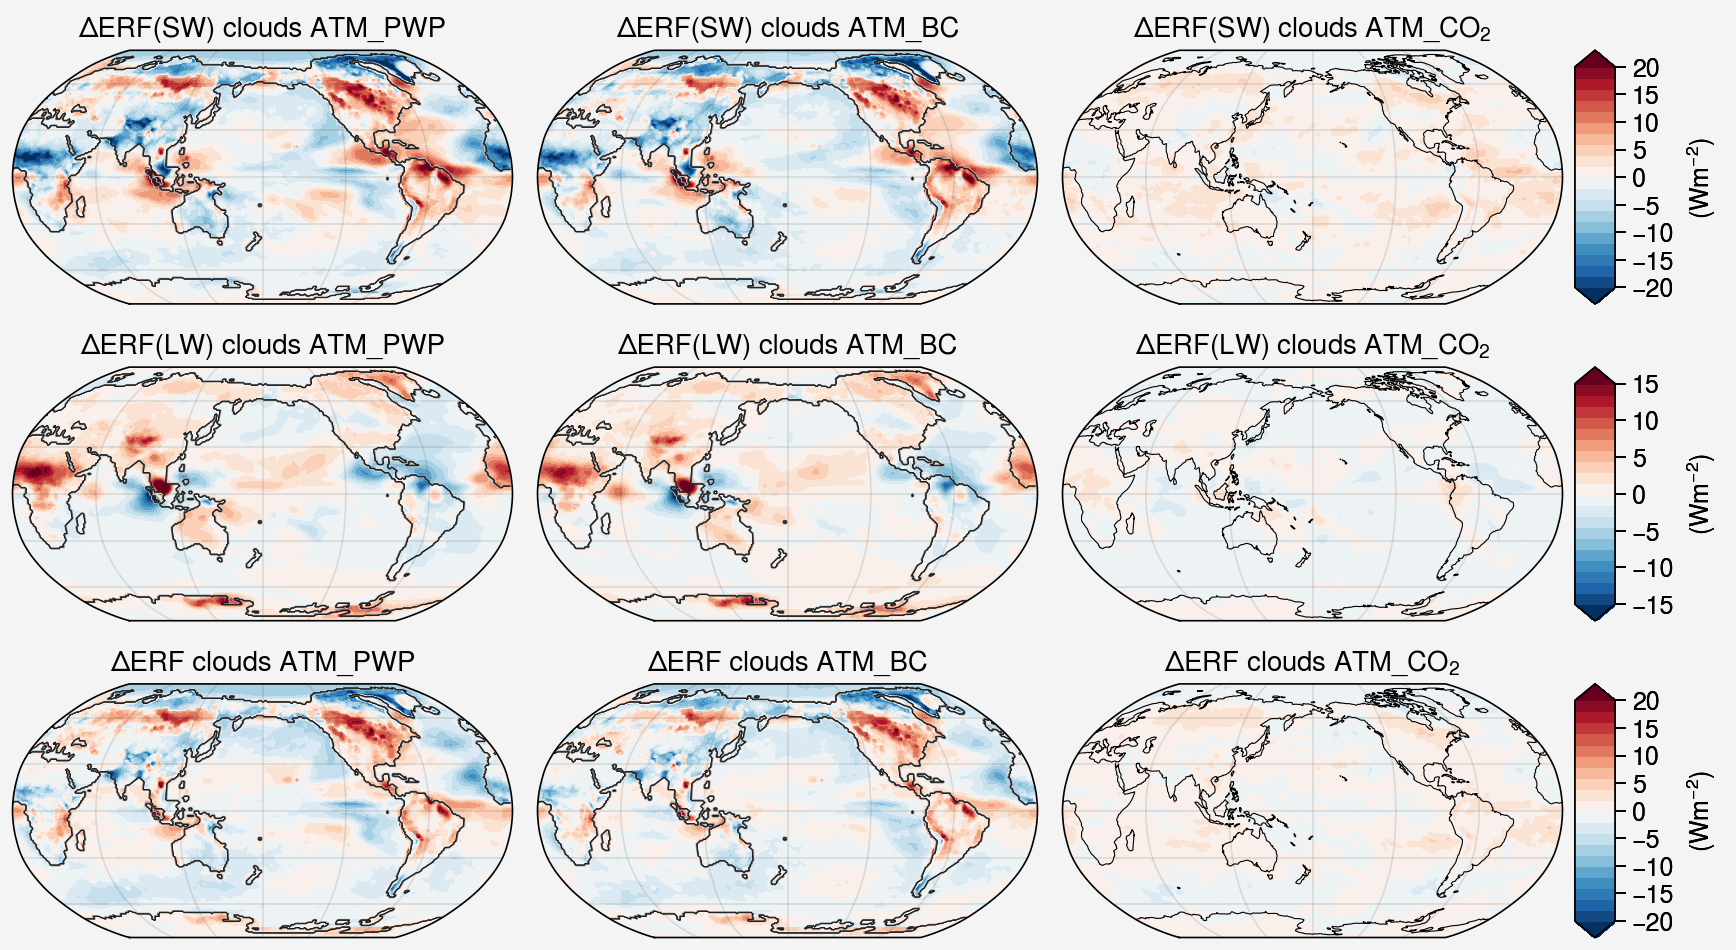

In [29]:
plt.rcParams["font.size"] = 9

fig, axes = pplt.subplots(nrows=3, ncols=3, proj='robin', proj_kw={'lon_0': 180})

for i,ax in enumerate(axes[:3]):
    cp = ax.contourf(SW_diff_clouds[i], cmap='RdBu_r', N=np.linspace(-20,20,21), extend='both')
    
    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)

axes[2].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[0].set_title('\u0394ERF(SW) clouds ATM-mPWP')
axes[1].set_title('\u0394ERF(SW) clouds ATM-BC')
axes[2].set_title('\u0394ERF(SW) clouds ATM-CO$_2$')
axes[2].coastlines(linewidth=0.4)

for i,ax in enumerate(axes[3:6]):
    cp = ax.contourf(LW_diff_clouds[i], cmap='RdBu_r', N=np.linspace(-15,15,21), extend='both')
    
    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
            
axes[5].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[3].set_title('\u0394ERF(LW) clouds ATM-mPWP')
axes[4].set_title('\u0394ERF(LW) clouds ATM-BC')
axes[5].set_title('\u0394ERF(LW) clouds ATM-CO$_2$')
axes[5].coastlines(linewidth=0.4)
            
for i,ax in enumerate(axes[6:]):
    cp = ax.contourf(net_diff_clouds[i], cmap='RdBu_r', N=np.linspace(-20,20,21), extend='both')

    if i != 2:
        cf = ax.contour(mask.mask, cmap='black', linewidth=0.3)
    
            
axes[8].colorbar(cp,label='(W$m^{-2}$)', ticks=5, length=1.0)
#ax.coastlines()
axes[6].set_title('\u0394ERF clouds ATM-mPWP')
axes[7].set_title('\u0394ERF clouds ATM-BC')
axes[8].set_title('\u0394ERF clouds ATM-CO$_2$')
axes[8].coastlines(linewidth=0.4);

In [17]:
u_plio_diff = (f_plio_wind.U.isel(lev=-1).mean('time') - f_pi_wind.U.isel(lev=-1).mean('time')).sel(lat=slice(-80,80))
u_plio_pidiff = (f_plio_280_wind.U.isel(lev=-1).mean('time') - f_pi_wind.U.isel(lev=-1).mean('time')).sel(lat=slice(-80,80))
u_co2_diff = (f_400_wind.U.isel(lev=-1).mean('time') - f_pi_wind.U.isel(lev=-1).mean('time')).sel(lat=slice(-80,80))

v_plio_diff = (f_plio_wind.V.isel(lev=-1).mean('time') - f_pi_wind.V.isel(lev=-1).mean('time')).sel(lat=slice(-80,80))
v_plio_pidiff = (f_plio_280_wind.V.isel(lev=-1).mean('time') - f_pi_wind.V.isel(lev=-1).mean('time')).sel(lat=slice(-80,80))
v_co2_diff = (f_400_wind.V.isel(lev=-1).mean('time') - f_pi_wind.V.isel(lev=-1).mean('time')).sel(lat=slice(-80,80))

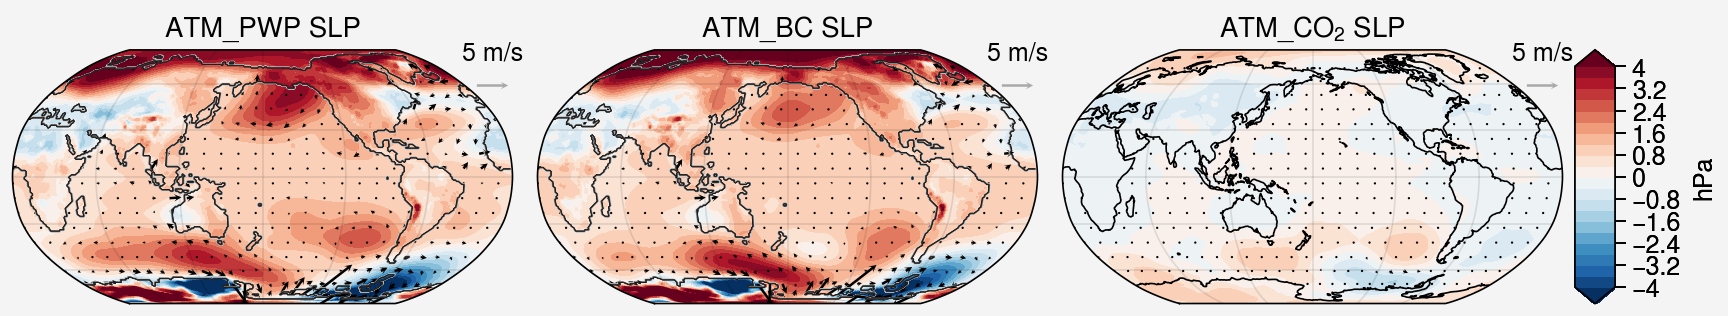

In [21]:
plio_SLP = f_plio_ref_slp.PSL.mean('time') / 1e2
pi_SLP = f_pi_ref_slp.PSL.mean('time') / 1e2
plio_280_SLP = f_plio_280_ref_slp.PSL.mean('time') / 1e2
co2_SLP = f_400_ref_slp.PSL.mean('time') / 1e2

SLP = [plio_SLP - pi_SLP, plio_280_SLP - pi_SLP, co2_SLP - pi_SLP]
titles = ['ATM-mPWP SLP', 'ATM-BC SLP', 'ATM-CO$_2$ SLP']
U = [u_plio_diff.where(ocnfrac_plio.OCNFRAC.mean('time') > 0), 
     u_plio_pidiff.where(ocnfrac_plio.OCNFRAC.mean('time') > 0), 
     u_co2_diff.where(ocnfrac_pi.OCNFRAC.mean('time') > 0)]
V = [v_plio_diff.where(ocnfrac_plio.OCNFRAC.mean('time') > 0), 
     v_plio_pidiff.where(ocnfrac_plio.OCNFRAC.mean('time') > 0), 
     v_co2_diff.where(ocnfrac_pi.OCNFRAC.mean('time') > 0)]

fig, axs = pplt.subplots(nrows=1,ncols=3, proj='robin', proj_kw={'lon_0':180})

for i,ax in enumerate(axs):
    cp = ax.contourf(SLP[i], N=np.linspace(-4,4,21), extend='both')
    qv1 = ax.quiver(U[i][::10,::10], V[i][::10,::10], scale_units='width', scale=80,
                     width=0.005, headaxislength=2, headlength=3, color='black')
    ax.set_title(titles[i])
    ax.quiverkey(qv1, 0.96, 0.86, 5, label='5 m/s', color='darkgray')

    if i !=2:
        ax.contour(mask.mask, cmap='black', linewidth=0.3)
        
    else:
        ax.coastlines()
            
axs[2].colorbar(cp, label='hPa');

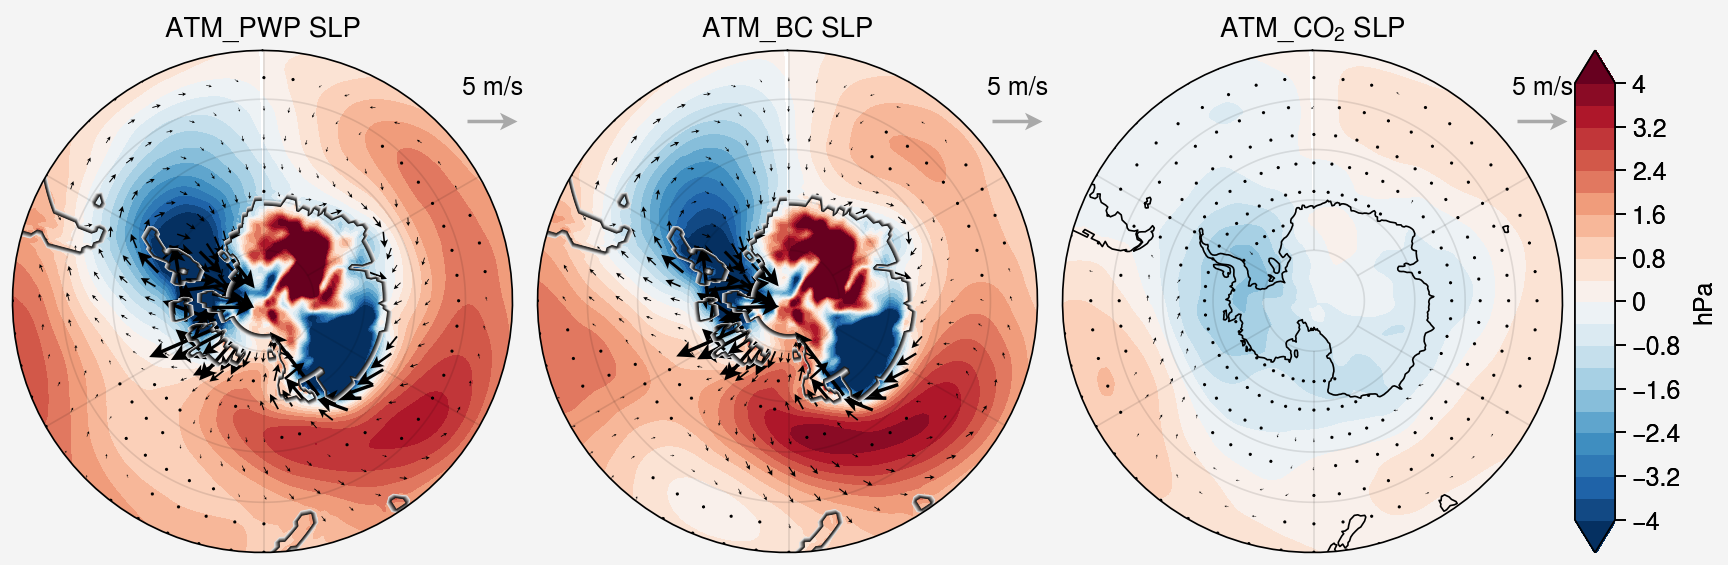

In [167]:
plio_SLP = f_plio_ref_slp.PSL.mean('time') / 1e2
pi_SLP = f_pi_ref_slp.PSL.mean('time') / 1e2
plio_280_SLP = f_plio_280_ref_slp.PSL.mean('time') / 1e2
co2_SLP = f_co2_ref_slp.PSL.mean('time') / 1e2

SLP = [plio_SLP - pi_SLP, plio_280_SLP - pi_SLP, co2_SLP - pi_SLP]
titles = ['ATM-mPWP SLP', 'ATM-BC SLP', 'ATM-CO$_2$ SLP']

fig, axs = pplt.subplots(nrows=1,ncols=3, proj='spaeqd', proj_kw={'lon_0':0})

for i,ax in enumerate(axs):
    cp = ax.contourf(SLP[i], N=np.linspace(-4,4,21), extend='both')
    qv1 = ax.quiver(U[i][::6,::6], V[i][::6,::6], scale_units='inches', scale=20,
                     width=0.007, headaxislength=4, headwidth=5, minshaft=2, color='black')
    ax.set_title(titles[i])
    ax.quiverkey(qv1, 0.96, 0.86, 5, label='5 m/s', color='darkgray')
    ax.format(boundinglat=-40)
    
    if i !=2:
        ax.contour(mask.mask, cmap='black', linewidth=0.3)
        
    else:
        ax.coastlines()
            
axs[2].colorbar(cp, label='hPa');

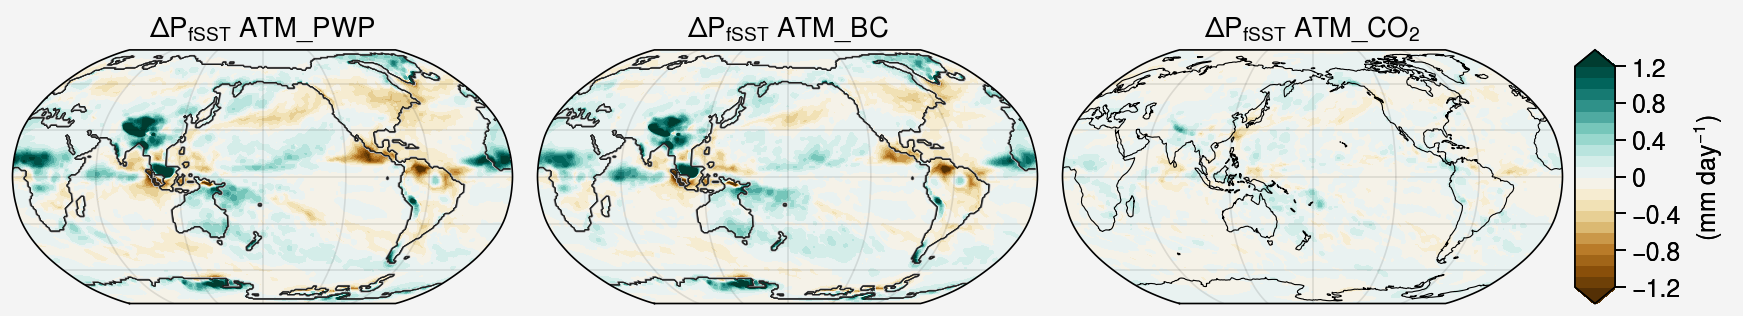

In [17]:
model_diff = (f_plio_precip.PRECL.mean("time") - f_pi_precip.PRECL.mean("time")) * 1e3 * 86400

fig, ax = pplt.subplots(nrows=1, ncols=3, proj='robin', proj_kw={'lon_0': 180})
cf = ax[0].contour(mask.mask, cmap='black', linewidth=0.3)
cp = ax[0].contourf(model_diff, cmap='BrBG', N=np.linspace(-1.2,1.2,21), extend='both')
#ax[0].colorbar(cp,label='(°C)', ticks=0.4, length=1.0)
#ax.coastlines()

model_diff = (f_plio_280_precip.PRECL.mean("time") - f_pi_precip.PRECL.mean("time")) * 1e3 * 86400

cf = ax[1].contour(mask.mask, cmap='black', linewidth=0.3)
cp = ax[1].contourf(model_diff, cmap='BrBG', N=np.linspace(-1.2,1.2,21), extend='both')
#ax[1].colorbar(cp,label='(°C)', ticks=0.4, length=1.0)
#ax.coastlines()

model_diff =  (f_400_precip.PRECL.mean("time") - f_pi_precip.PRECL.mean("time")) * 1e3 * 86400

#cf = ax[2].contour(mask.mask, cmap='black', linewidth=0.3)
cp = ax[2].contourf(model_diff, cmap='BrBG', N=np.linspace(-1.2,1.2,21), extend='both')
ax[2].colorbar(cp,label='(mm day$^{-1}$)', ticks=0.4, length=1.0)
ax[2].coastlines(linewidth=0.4)

ax[0].set_title('\u0394P$_{fSST}$ ATM-mPWP')
ax[1].set_title('\u0394P$_{fSST}$ ATM-BC')
ax[2].set_title('\u0394P$_{fSST}$ ATM-CO$_2$');